In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools

from stripROtools import colors



In [2]:
# dataframe with time offset info
T_off = pd.read_pickle("./data/time_offset.pk")
T_off


,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


In [3]:
# make a df to store results for all cases

df_resolution = pd.DataFrame(columns = ['Name','x_res', 'x_res_err', 'y_res', 'y_res_err','abs_z'])

In [4]:
# Solid angle range in theta [degrees]
theta_min = 15
theta_max = 30


# UH DLC Micromegas - Quadrant a

In [5]:
# Location of experimental data files

file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]

# multiplicative factor found in Fe55_vmm.ipynb for agreement with PHA analysis
Mult_factor = 1.24

# The edges of the x and y hits
strip_edges = np.arange(-0.5,499.5,1.0)

# Other Parameters
pitch_x = 200               # in um
pitch_y = 200               # in um
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0     # in mV/fC
electronic_gain_y = 4.5     # in mV/fC

# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3



----------- Vmesh =  540 -----------
selecting tracks fiducial on quadrant a...
----- Hits on y strips -----


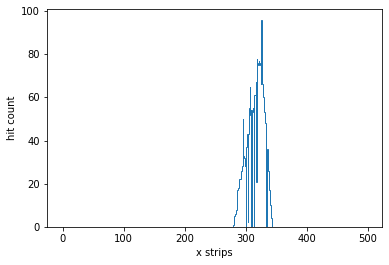

----- Hits on y strips -----


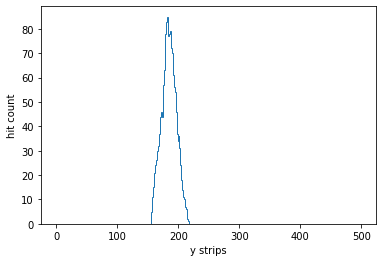

----- Event Time Range-----


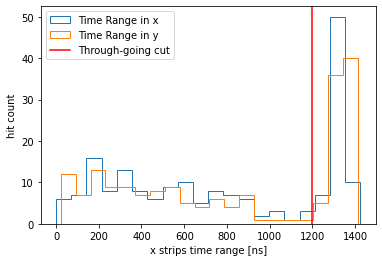

----- ADC distribution-----


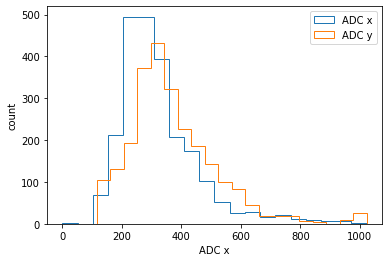

selecting through-going tracks within 25 degrees of vertical...
Number of remaining events:  59
----- hits in x and y  -----


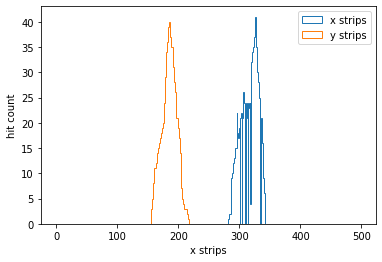

sigma x:  -50.04982906016216 +/- 0.005805460853905622
sigma y:  50.445896917413975 +/- 0.004317810404185013


/Users/majdghrear/Lab/2DstripRO/stripROtools.py:663: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


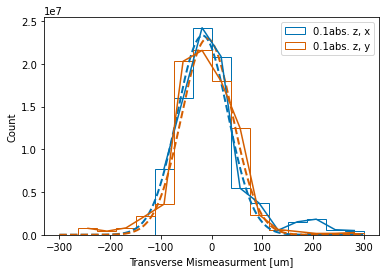

sigma x:  44.43407377039705 +/- 0.003628277620880772
sigma y:  38.71300447400633 +/- 0.0030320802692862725


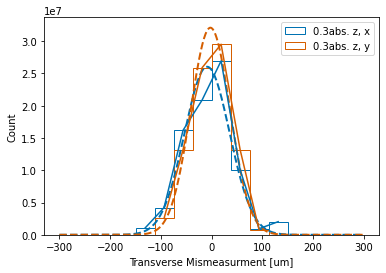

sigma x:  46.346814031930485 +/- 0.003994072201696219
sigma y:  35.84017051963631 +/- 0.002939274111501737


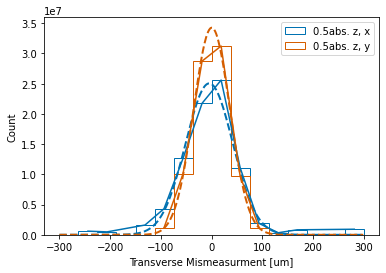

sigma x:  -50.04970302430083 +/- 0.004729624925599587
sigma y:  -49.25321611019264 +/- 0.004840196741866537


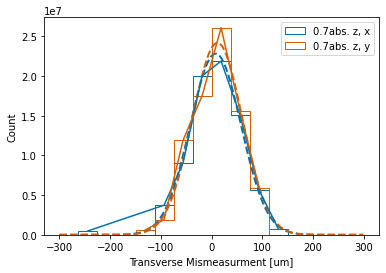

sigma x:  59.37994061705787 +/- 0.0053473909020365805
sigma y:  47.60030752992443 +/- 0.004368355677745958


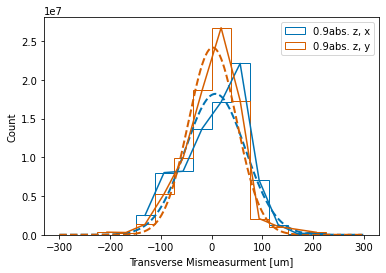

sigma x:  86.83921024065002 +/- 0.013972833291927353
sigma y:  94.02142022034359 +/- 0.017535986407847412


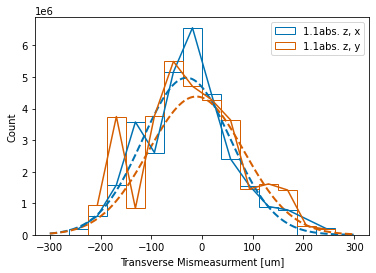

sigma x:  53.40381900553617 +/- 0.002191872564113019
sigma y:  43.02733132797386 +/- 0.001629501037185544


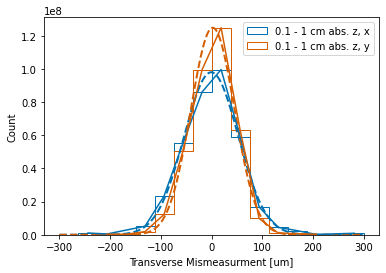

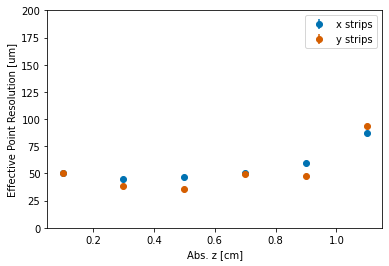

In [6]:
for V in [540]:

    print("-----------", "Vmesh = ", str(V), "-----------")

    # Create pandas data frame of the cluster info
    df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)

    # Define additional columns

    # number of hits
    df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)
    df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x  / (9.0 *  Mult_factor) ) ) # 9 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / (4.5 * Mult_factor ) ) ) # 4.5 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y

    # length on x/y plane in units of strip lengths
    df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

    # time range on x strips
    df_cluster["TR0"] = df_cluster.times0.apply(np.max)-df_cluster.times0.apply(np.min)

    # time range on y strips
    df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)

    print("selecting tracks fiducial on quadrant a...")
    
    #fiducialize clusters on s ingle vmmm combo in xHyL
    df_cluster = stripROtools.fiducializeVMM(df_cluster, n_vmm_x=5, n_vmm_y=10, min_hits=5, map="UH")


    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()
    # plot the y hits

    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("y strips")
    plt.ylabel("hit count")
    plt.show()

    # Plot the time range in x, throughgoing alphas take up the largets time range
    print("----- Event Time Range-----")

    plt.figure()
    plt.hist(df_cluster["TR0"],bins=20,histtype='step', label="Time Range in x")
    plt.hist(df_cluster["TR1"],bins=20,histtype='step', label="Time Range in y")
    plt.axvline(1200, color='r',label="Through-going cut")
    plt.xlabel("x strips time range [ns]")
    plt.ylabel("hit count")
    plt.legend()
    plt.show()


    #Plot ADC x distribution
    print("----- ADC distribution-----")

    plt.figure()
    plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step", label="ADC x")
    plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step", label="ADC y")
    plt.xlabel("ADC x")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    print("selecting through-going tracks within 25 degrees of vertical...")

    # Cut for throughgoing events  with over 8 hits 
    df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) ]
    df_cut=df_cut.reset_index(drop=True)

    print("Number of remaining events: ", len(df_cut) )

    print("----- hits in x and y  -----")

    # Plot x hits

    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step',label= "x strips")
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step',label= "y strips")
    plt.legend()
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])
    all_c = np.array([])

    # Loop through tracks after all selection cuts
    for indx in range(len(df_cut)):

        try:

            event = df_cut.iloc[indx]

            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = event, Mult_factor = Mult_factor, gain_x=electronic_gain_x, gain_y=electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, v_drift=8.0, pitch_x=pitch_x, pitch_y=pitch_y)

            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                    all_c = np.append(all_c,c)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Get mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c, start = 0.0, stop = 1.2, step = 0.2)


    plt.figure()
    plt.errorbar(abs_z,x_sigmas2,x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,y_sigmas2,y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

df_resolution = df_resolution.append({'Name' : "UH_DLC_a", 'x_res' : x_sigmas2, 'x_res_err' : x_sigmas_err2, 'y_res' : y_sigmas2, 'y_res_err' :  y_sigmas_err2, 'abs_z' : abs_z }, ignore_index = True)




# UH NoDLC Micromegas - Quadrant a

In [7]:
# Location of experimental data files

file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_NoDLC/Po210/540Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_NoDLC/Po210/540Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]

# multiplicative factor found in Fe55_vmm.ipynb for agreement with PHA analysis
Mult_factor = 1.10

# The edges of the x and y hits
strip_edges = np.arange(-0.5,499.5,1.0)

# Other Parameters
pitch_x = 200
pitch_y = 200
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0
electronic_gain_y = 4.5

# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3




----------- Vmesh =  540 -----------
selecting tracks fiducial on quadrant a...
----- Hits on y strips -----


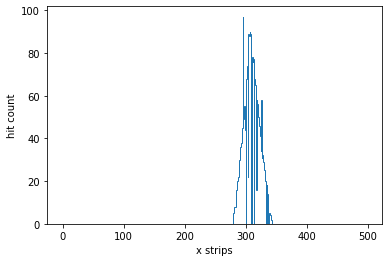

----- Hits on y strips -----


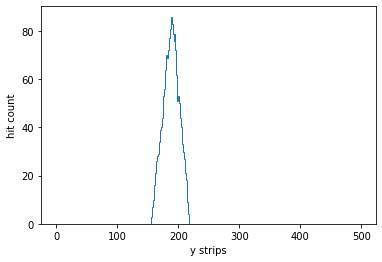

----- Event Time Range-----


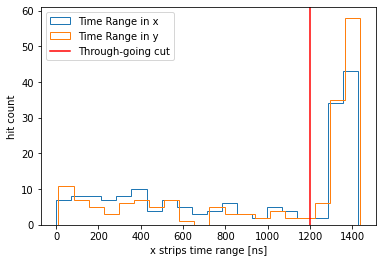

----- ADC distribution-----


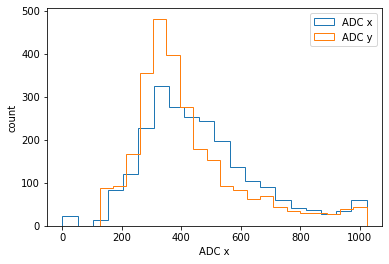

selecting through-going tracks within 25 degrees of vertical...
Number of remaining events:  68
----- hits in x and y  -----


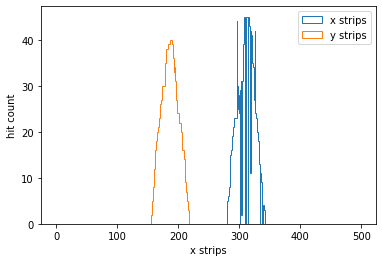

sigma x:  -53.41778943593754 +/- 0.0038269919982101656
sigma y:  -48.005407537699064 +/- 0.0034597776427649765


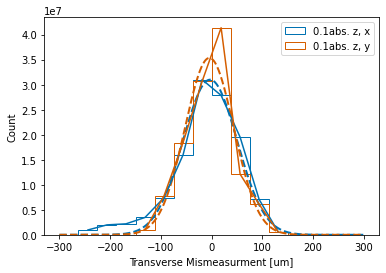

sigma x:  53.49767321133675 +/- 0.0038115064195807405
sigma y:  44.934178574039585 +/- 0.002949286337394496


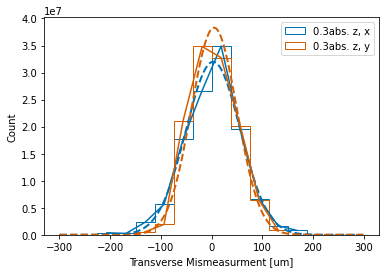

sigma x:  43.29137582660548 +/- 0.0031586131863378898
sigma y:  47.443969720185976 +/- 0.0038409241026880966


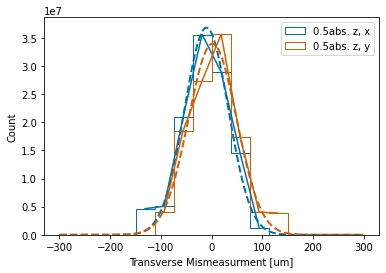

sigma x:  50.24231447331826 +/- 0.003533758908168723
sigma y:  46.75949941487328 +/- 0.003910278538751374


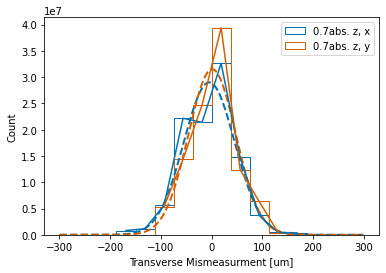

sigma x:  50.410193275254436 +/- 0.0041021558466770485
sigma y:  50.532828888483905 +/- 0.003925822834081363


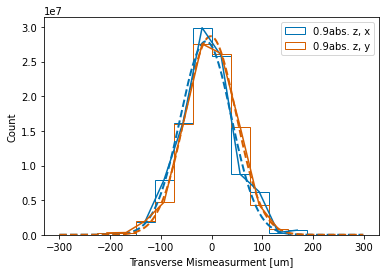

sigma x:  -82.60104300237637 +/- 0.00948915813226911
sigma y:  90.6792062631359 +/- 0.01001754442408527


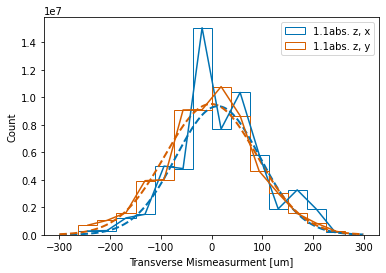

sigma x:  51.48945492929117 +/- 0.001707723693864461
sigma y:  47.928459251075644 +/- 0.0016138457544504904


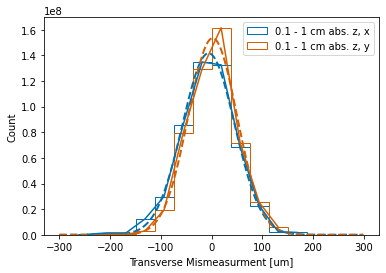

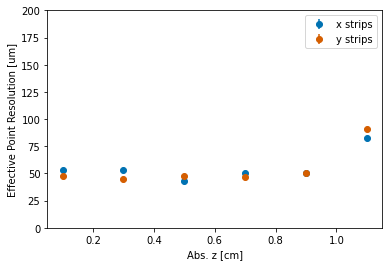

In [8]:
for V in [540]:

    print("-----------", "Vmesh = ", str(V), "-----------")

    # Create pandas data frame of the cluster info
    df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)

    # Define additional columns

    # number of hits
    df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)
    df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x  / (9.0 *  Mult_factor) ) ) # 9 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / (4.5 * Mult_factor ) ) ) # 4.5 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y

    # length on x/y plane in units of strip lengths
    df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

    # time range on x strips
    df_cluster["TR0"] = df_cluster.times0.apply(np.max)-df_cluster.times0.apply(np.min)

    # time range on y strips
    df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)

    print("selecting tracks fiducial on quadrant a...")
    
    #fiducialize clusters on s ingle vmmm combo in xHyL
    df_cluster = stripROtools.fiducializeVMM(df_cluster, n_vmm_x=5, n_vmm_y=10, min_hits=5, map="UH")


    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()
    # plot the y hits

    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("y strips")
    plt.ylabel("hit count")
    plt.show()

    # Plot the time range in x, throughgoing alphas take up the largets time range
    print("----- Event Time Range-----")

    plt.figure()
    plt.hist(df_cluster["TR0"],bins=20,histtype='step', label="Time Range in x")
    plt.hist(df_cluster["TR1"],bins=20,histtype='step', label="Time Range in y")
    plt.axvline(1200, color='r',label="Through-going cut")
    plt.xlabel("x strips time range [ns]")
    plt.ylabel("hit count")
    plt.legend()
    plt.show()


    #Plot ADC x distribution
    print("----- ADC distribution-----")

    plt.figure()
    plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step", label="ADC x")
    plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step", label="ADC y")
    plt.xlabel("ADC x")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    print("selecting through-going tracks within 25 degrees of vertical...")

    # Cut for throughgoing events  with over 8 hits 
    df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) ]
    df_cut=df_cut.reset_index(drop=True)

    print("Number of remaining events: ", len(df_cut) )

    print("----- hits in x and y  -----")

    # Plot x hits

    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step',label= "x strips")
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step',label= "y strips")
    plt.legend()
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()

    # Analyze point resolution
    all_c = np.array([])
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])

    # Loop through tracks after all selection cuts
    for indx in range(len(df_cut)):

        try:

            event = df_cut.iloc[indx]

            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = event, Mult_factor = Mult_factor, gain_x=electronic_gain_x, gain_y=electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, v_drift=8.0, pitch_x=pitch_x, pitch_y=pitch_y)

            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_c = np.append(all_c,c)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Git mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c, start = 0.0, stop = 1.2, step = 0.2)


    plt.figure()
    plt.errorbar(abs_z,x_sigmas2,x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,y_sigmas2,y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

df_resolution = df_resolution.append({'Name' : "UH_NoDLC_a", 'x_res' : x_sigmas2, 'x_res_err' : x_sigmas_err2, 'y_res' : y_sigmas2, 'y_res_err' :  y_sigmas_err2, 'abs_z' : abs_z }, ignore_index = True)




# UoS

In [9]:
# Location of experimental data files

file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UoS/Po210/870Vmesh_1_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UoS/Po210/870Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]

# multiplicative factor found in Fe55_vmm.ipynb for agreement with PHA analysis
Mult_factor = 1.41

# The edges of the x and y hits
strip_edges = np.arange(-0.5,357.5,1.0)

# Other Parameters
pitch_x = 250
pitch_y = 250
n_strips_x = 358
n_strips_y = 358
electronic_gain_x = 1.0
electronic_gain_y = 1.0

# 3D clustering paramters
mu = T_off.iloc[8]["Mu"]
sigma = T_off.iloc[8]["Sigma"]
n_sigma = 3




----------- Vmesh =  870 -----------
----- Hits on x strips -----


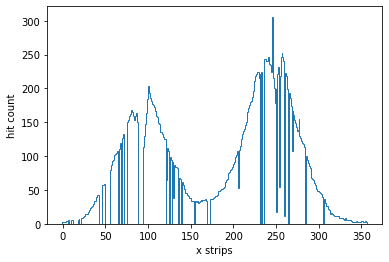

----- Hits on y strips -----


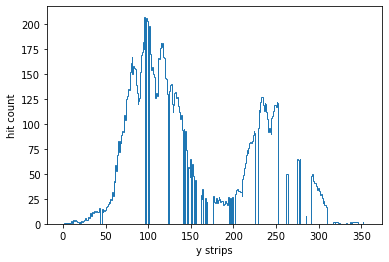

----- Event Time Range-----


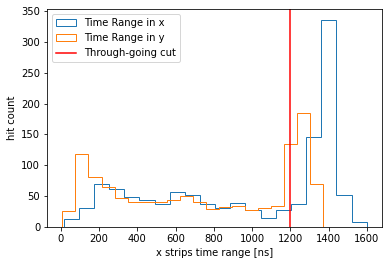

----- ADC distribution-----


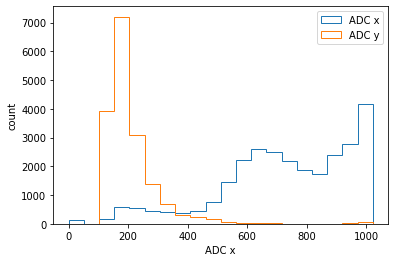

selecting through-going tracks within 25 degrees of vertical...
Number of remaining events:  259
----- hits in x and y  -----


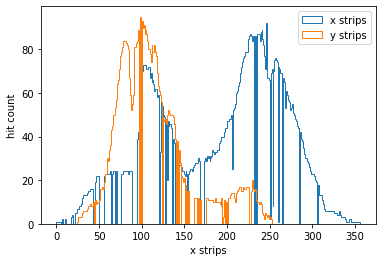

/Users/majdghrear/Lab/2DstripRO/stripROtools.py:663: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


sigma x:  132.64832271024758 +/- 0.019905235823166084
sigma y:  37.85391656745139 +/- 0.0032874021943314425


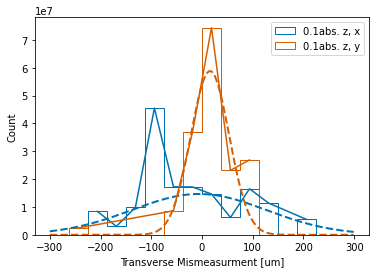

sigma x:  119.22275856842957 +/- 0.04069143282315337
sigma y:  56.35168087298243 +/- 0.014237698816130247


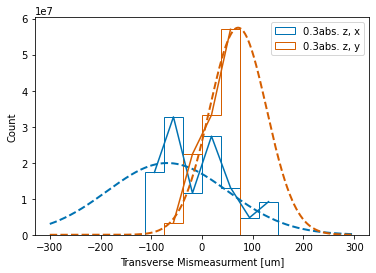

sigma x:  95.29449250388424 +/- 0.012719821467857736
sigma y:  39.26923711007684 +/- 0.003274754635278163


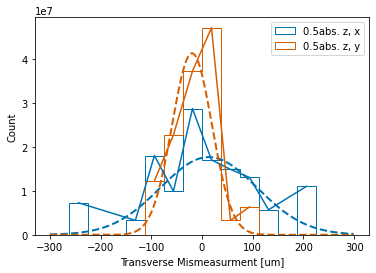

sigma x:  83.82918354819857 +/- 0.0071615338670160695
sigma y:  -44.76922660814677 +/- 0.004467987694555608


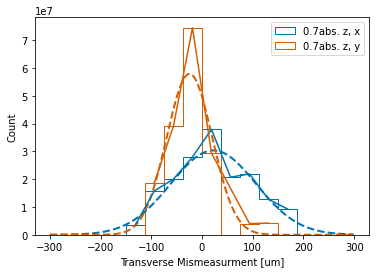

sigma x:  124.46680829040606 +/- 0.013257084967000673
sigma y:  64.44752769648169 +/- 0.004347138916373715


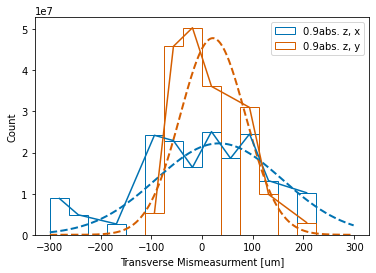

fit failed for z =  1.1
sigma x:  75.62781636134541 +/- 0.002393415099800125
sigma y:  51.78792042227257 +/- 0.0020087427783515434


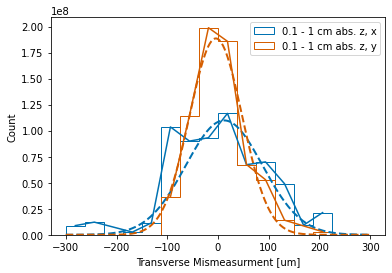

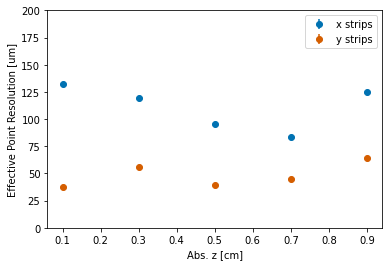

In [12]:
# WARNING: over here the x strips are the upper strips
# However, the convention in the paper is to call the y strips the upper strips
# We use the paper's convention in point_res.ipynb (i.e. the x strips are relabeled as the y strips)


for V in [870]:

    print("-----------", "Vmesh = ", str(V), "-----------")

    # Create pandas data frame of the cluster info
    df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)

    # Define additional columns

    # number of hits
    df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)
    df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x / (1.0*Mult_factor) ) ) # 1 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / (1.0*Mult_factor) ) ) # 1 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y


    # length on x/y plane in units of strip lengths
    df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

    # time range on x strips
    df_cluster["TR0"] = df_cluster.times0.apply(np.max)-df_cluster.times0.apply(np.min)

    # time range on y strips
    df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)




    print("----- Hits on x strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()
    # plot the y hits

    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("y strips")
    plt.ylabel("hit count")
    plt.show()

    # Plot the time range in x, throughgoing alphas take up the largets time range
    print("----- Event Time Range-----")

    plt.figure()
    plt.hist(df_cluster["TR0"],bins=20,histtype='step', label="Time Range in x")
    plt.hist(df_cluster["TR1"],bins=20,histtype='step', label="Time Range in y")
    plt.axvline(1200, color='r',label="Through-going cut")
    plt.xlabel("x strips time range [ns]")
    plt.ylabel("hit count")
    plt.legend()
    plt.show()


    #Plot ADC x distribution
    print("----- ADC distribution-----")

    plt.figure()
    plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step", label="ADC x")
    plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step", label="ADC y")
    plt.xlabel("ADC x")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    print("selecting through-going tracks within 25 degrees of vertical...")

    # Cut for throughgoing events  with over 8 hits 
    df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) ]
    df_cut=df_cut.reset_index(drop=True)

    print("Number of remaining events: ", len(df_cut) )

    print("----- hits in x and y  -----")

    # Plot x hits

    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step',label= "x strips")
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step',label= "y strips")
    plt.legend()
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()

    # Analyze point resolution
    all_z = np.array([])
    all_c = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])

    # Loop through tracks after all selection cuts
    for indx in range(len(df_cut)):

        try:

            event = df_cut.iloc[indx]

            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = event, Mult_factor = Mult_factor, gain_x=electronic_gain_x, gain_y=electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, v_drift=8.0, pitch_x=pitch_x, pitch_y=pitch_y)

            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_c = np.append(all_c,c)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Git mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c, start = 0.0, stop = 1.2, step = 0.2)


    plt.figure()
    plt.errorbar(abs_z,x_sigmas2,x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,y_sigmas2,y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

df_resolution = df_resolution.append({'Name' : "UoS", 'x_res' : x_sigmas2, 'x_res_err' : x_sigmas_err2, 'y_res' : y_sigmas2, 'y_res_err' :  y_sigmas_err2, 'abs_z' : abs_z }, ignore_index = True)




In [11]:
df_resolution.to_pickle("./data/resolution_exp.pk")
df_resolution

,Name,x_res,x_res_err,y_res,y_res_err,abs_z
0,UH_DLC_a,"[50.04982906016216, 44.43407377039705, 46.3468...","[0.005805460853905622, 0.003628277620880772, 0...","[50.445896917413975, 38.71300447400633, 35.840...","[0.004317810404185013, 0.0030320802692862725, ...","[0.1, 0.3, 0.5, 0.7, 0.9, 1.1]"
1,UH_NoDLC_a,"[53.41778943593754, 53.49767321133675, 43.2913...","[0.0038269919982101656, 0.0038115064195807405,...","[48.005407537699064, 44.934178574039585, 47.44...","[0.0034597776427649765, 0.002949286337394496, ...","[0.1, 0.3, 0.5, 0.7, 0.9, 1.1]"
2,UoS,"[132.64832271024758, 119.22275856842957, 95.29...","[0.019905235823166084, 0.04069143282315337, 0....","[37.85391656745139, 56.35168087298243, 39.2692...","[0.0032874021943314425, 0.014237698816130247, ...","[0.1, 0.3, 0.5, 0.7, 0.9]"
